In [70]:
import numpy as np
import numba
from numba.types import *
from numba import prange
import matplotlib.pyplot as plt
from numpy.linalg import eig, multi_dot, inv, matrix_power, eigh
from scipy.optimize import curve_fit
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['font.size']=22
from matplotlib.ticker import ScalarFormatter
from scipy.linalg import expm, sqrtm
from scipy.stats import linregress
from math import acos, factorial
from scipy.special import eval_genlaguerre, gamma

In [38]:
i=complex(0,1)

In [39]:
@numba.jit(float64(float64[:], float64[:]), nopython=True)
def braket(bra, ket):
    if np.all(bra== ket):
        return 1
    else:
        return 0
@numba.jit(complex128[:,:](complex128[:], complex128[:]), nopython=True)
def ketbra(ket, bra):
    dim=len(ket)
    res=np.zeros((dim, dim), dtype=complex128)
    for j in range(dim):
        for k in range(dim):
            res[j,k]=ket[j]*np.conjugate(bra[k])
    return res
@numba.jit(numba.types.Tuple((float64, float64[:]))(float64[:], float64, int64), nopython=True)
def S_p(ket, S, dim):
    site= np.argmax(ket)
    m=site-S
    ket_out=np.zeros(dim)
    if site== 2*S:
        coef=0
        return (coef, ket_out)
    else:
        coef=np.sqrt(S*(S+1)-m*(m+1))
        ket_out[site+1]= 1
        return (coef, ket_out)
@numba.jit(numba.types.Tuple((float64, float64[:]))(float64[:], float64, int64), nopython=True)
def S_m(ket, S, dim):
    site= np.argmax(ket)
    m=site-S
    ket_out=np.zeros(dim)
    if site== 0:
        coef=0
        return (coef, ket_out)
    else:
        coef= np.sqrt(S*(S+1)-m*(m-1))
        ket_out[site-1]= 1
        return (coef, ket_out)
@numba.jit(complex128[:,:](float64[:, :], float64), nopython=True)
def Compute_Sx(basis, S):
    dim=int(2*S+1)
    Sx=np.zeros((dim, dim), dtype=complex128)
    for j in range(dim):
        for k in range(dim):
            ket=basis[j, :]
            bra=basis[k, :]
            coef_p, S_p_ket=S_p(ket, S, dim)
            coef_m, S_m_ket=S_m(ket, S, dim)
            result_p=braket(bra, S_p_ket)
            result_m=braket(bra, S_m_ket)
            Sx[j, k]=(coef_p*result_p+ coef_m*result_m)/2
    return Sx

@numba.jit(complex128[:,:](float64[:, :], float64), nopython=True)
def Compute_Sy(basis, S):
    dim=int(2*S+1)
    Sy=np.zeros((dim, dim), dtype=complex128)
    i=complex(0,1)
    for j in range(dim):
        for k in range(dim):
            ket=basis[j, :]
            bra=basis[k, :]
            coef_p, S_p_ket=S_p(ket, S, dim)
            coef_m, S_m_ket=S_m(ket, S, dim)
            result_p=braket(bra, S_p_ket)
            result_m=braket(bra, S_m_ket)
            Sy[j, k]=-i*(coef_p*result_p- coef_m*result_m)/2
    return Sy

@numba.jit(float64[:,:](float64), nopython=True)
def Compute_Sz(S):
    dim=int(2*S+1)
    Sz=np.zeros((dim, dim))
    for j in range(dim):
        m=j-S
        Sz[dim-1-j, dim-1-j]=m
    return Sz

In [40]:
@numba.jit(float64[:,:](int64, float64), nopython=True, parallel=False, fastmath=True)
def RMT_GOE(N, sigma):
    auxH = np.random.randn(N,N)
    H=(auxH+auxH.T)
    return H
@numba.jit(complex128[:,:](int64, float64), nopython=True, parallel=False, fastmath=True)
def RMT_GUE(N, sigma):
    H=np.zeros((N, N), dtype=complex128)
    for j in range(N):
        H[j,j]=np.random.normal(0,sigma)
        for k in range(j+1, N):
            a=np.random.normal(0,sigma)/np.sqrt(2)
            b=np.random.normal(0,sigma)/np.sqrt(2)
            H[j,k]=complex(a,b)
            H[k,j]=complex(a,-b)
    #auxH=np.random.randn(N, N)+i*np.random.randn(N, N)
    #H=(auxH+auxH.conj().T)/2
    return H

In [41]:
#Regularized OTOC
@numba.njit()
#def F(y, E, ket_n, t, psi0, G, dphi, dim, β):
def FidOTOC( E, t, psi0, expG, dphi, dim, β):
    """evt=Evt(E, t, ket_n)
    invevt=Evt(E,-t,ket_n)
    W=createW(dphi, G, ket_n)
    F=(np.abs(np.conjugate(psi0)@y@invevt@W@evt@y@psi0))**2"""
    F=0
    for m in range(dim):
        for n in range(dim):
            F+=np.conjugate(psi0[m])*psi0[n]*np.exp(-β*(E[m]+E[n])/4)*np.exp(i*(E[m]-E[n])*t)*expG[m,n]
    F=(np.abs(F))**2
    return F
@numba.jit(complex128(complex128[:,:],  complex128[:,:], complex128[:,:],  complex128[:,:], complex128[:,:]), nopython=True, parallel=False, fastmath=True)
def OTOC(y, V, W, U, invU):
    #F=0
    #V=ket_n@Compute_Sz((dim-1)/2,dim)@np.transpose(np.conjugate(ket_n))
    #V=Compute_Sz((dim-1)/2, dim)
    #evt=np.diag(np.exp(-i*E*t))
    W_t=invU@W@U
    #W_t=invU@V@U
    """V=np.zeros((dim, dim), dtype=complex128)
    W_t=np.zeros((dim, dim), dtype=complex128)
    for n in range(dim):
        for m in range(dim):
            auxnm=ketbra(ket_n[:,n], ket_n[:,m])
            V+=ketbra(ket_n[:,m], ket_n[:,n])
            W_t+=np.exp(i*(E[m]-E[n])*t/hbar)*auxnm"""
    F=np.trace(y@V@y@W_t@y@V@y@W_t)
    return F
@numba.njit()
def fastOTOC(V, W, E, t, β, dim):
    σ=β/4 + i*t
    σ_c=β/4 - i*t
    C=0
    for j in range(dim):
        for k in range(dim):
            for m in range(dim):
                for n in range(dim):
                    C+=np.exp(σ*E[j])*np.exp(σ_c*E[k])*np.exp(σ*E[m])*np.exp(σ_c*E[n])*V[j,k]*W[k,m]*V[m,n]*W[n,j]
    return C
@numba.njit()
def TwoPF(V, W, U, invU, rho):
    W_t=invU@W@U
    return np.real(np.trace(V@W_t@rho))
@numba.njit(float64(complex128[:,:], complex128[:,:], float64, float64[:], float64, int64))
def fast2PF(V, W, β, E, t, dim):
    B=0
    for n in range(dim):
        for m in range(dim):
            B+=V[n,m]*W[m,n]*np.exp(-β*E[n])*np.exp(-i*(E[n]-E[m])*t)
    return np.real(B)
#Compute the analytically continued partition function given the spectrum E of the system
#The β parameter may be complex valued.
@numba.njit()
def Z_c(β, E):
    Z=np.sum(np.exp(-β*E))
    return Z
@numba.njit()
def Averageaxis0(arr, d0, d1):
    arrout=np.zeros(d1)
    for k in range(d1):
        arrout[k]=np.sum(arr[:,k])/d0
    return arrout
@numba.njit()
def Average3d(arr, d0, d1, d2):
    arrout=np.zeros(d1)
    for k in range(d1):
        arrout[k]=np.sum(arr[:,k, :])/(d0*d2)
    return arrout
@numba.njit()
def defpsi0(dim):
    #Random state. Normalized
    #psi0=(np.random.rand(dim)-0.5)*2+i*(np.random.rand(dim)-0.5)*2
    psi0=(np.random.randn(dim)-0.5)*2+i*(np.random.randn(dim)-0.5)*2
    psi0=psi0/np.sqrt(np.sum(np.abs(psi0)**2))
    #Uniform state
    #psi0=np.ones(dim)/np.sqrt(dim)
    return psi0

@numba.njit()
def defy(E,β,ket_n, dim):
    evt=np.zeros((dim,dim), dtype=complex128)
    for k in range(dim):
        evt+=np.exp(-β*E[k]/4)*ketbra(ket_n[:,k], ket_n[:,k])
    return evt
@numba.njit()
def Evt(E,t,ket_n):
    dim=len(E)
    evt=np.zeros((dim,dim), dtype=complex128)
    for k in range(dim):
        evt+=np.exp(-i*E[k]*t)*ketbra(ket_n[:,k], ket_n[:,k])
    return evt

@numba.njit()
def createW(dphi,G, ket_n):
    #G should be in the eigenvector basis
    W=np.zeros((dim,dim), dtype=complex128)
    for k in range(dim):
        for j in range(dim):
            W+=np.exp(i*dphi*G[k,j])*ketbra(ket_n[:,k], ket_n[:,k])
    return W
#print(ket_n.shape)

<ipython-input-41-d9dc02de5644>:21: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(complex128, 2d, A), array(complex128, 2d, A))
  W_t=invU@W@U
<ipython-input-41-d9dc02de5644>:21: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(complex128, 2d, C), array(complex128, 2d, A))
  W_t=invU@W@U
<ipython-input-41-d9dc02de5644>:30: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(complex128, 2d, A), array(complex128, 2d, A))
  F=np.trace(y@V@y@W_t@y@V@y@W_t)
<ipython-input-41-d9dc02de5644>:30: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(complex128, 2d, C), array(complex128, 2d, A))
  F=np.trace(y@V@y@W_t@y@V@y@W_t)
/home/pablo/anaconda3/lib/python3.7/site-packages/numba/typing/npydecl.py:958: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(complex128, 2d, A), array(complex128, 2d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/pablo/a

In [42]:
#@numba.njit(numba.types.Tuple((float64[:], float64[:], float64))(int64, int64, float64, float64[:], int64, complex128[:,:], float64))
@numba.njit()
def AvTimeEv(Nav, β, dim, t_arr2, basis, V, W):
    nt=len(t_arr2)
    Farr=np.zeros((Nav,nt), dtype=complex128)
    Z_arr=np.zeros(Nav)
    Z_arr_aux=np.zeros((Nav, nt))
    SFF_aux=np.zeros((Nav, nt))
    TwoPF_aux=np.zeros((Nav, nt))
    #dt=t_arr[1]-t_arr[0]
    for j in range(Nav):
        H=RMT_GUE(dim, 1/np.sqrt(2))
        E,ket_n=eigh(H)
        V_=np.conj(np.transpose(ket_n))@V@ket_n
        W_=np.conj(np.transpose(ket_n))@W@ket_n
        if np.any(np.imag(E)>1e-8): 
            print("Problems") #Ensures that we have real eigenvalues
            print(np.max(np.imag(E)))
        Z=Z_c(β, E)
        Z_arr[j]=Z
        #y=defy(E, β, ket_n, dim)
        #rho=defy(E, 4*β, ket_n, dim)
        #U_dt=expm(-i*H*dt)
        #invU_dt=inv(U_dt)
        #U_n=np.identity(dim, dtype=complex)
        #invU_n=np.identity(dim, dtype=complex)
        for k in range(nt):
            Z_arr_aux[j,k]=Z
            SFF_aux[j, k]=(np.abs(Z_c(β/2+ 2*i*t_arr2[k], E)))**2
            #Farr[j,k, m]=FidOTOC(E, t_arr[k], psi0, expG, dphi, dim, β)
            Farr[j,k]=fastOTOC(V_, W_, E, t_arr2[k], β, dim)
            TwoPF_aux[j,k]=fast2PF(V_, W_, β, E, t_arr2[k], dim)
            #U_n=U_n@U_dt
            #invU_n=invU_n@invU_dt
    Fout_ann=Averageaxis0(np.real(Farr), Nav, nt)/np.mean(Z_arr)
    Fout_unann=Averageaxis0(np.real(Farr/Z_arr_aux), Nav, nt)
    SFF=Averageaxis0(SFF_aux, Nav, nt)
    TPF_ann=Averageaxis0(TwoPF_aux, Nav, nt)/np.mean(Z_arr)
    TPF_Nann=Averageaxis0(TwoPF_aux/Z_arr_aux, Nav, nt)
    return (Fout_ann, Fout_unann, np.mean(Z_arr), SFF, TPF_ann, TPF_Nann)

In [43]:
dim=20
A=1 #Probability distribution will be P~exp(-A x^2)
sigma=np.sqrt(A/2)
basis = np.identity(dim)
i=complex(0,1)
β=1
hbar=1
tmax=100
n_points_t=500
xlogscale=False
#t_arr=np.linspace(0, tmax, n_points_t)
auxtmin=-2
auxtmax=np.log10(tmax)
auxt=np.linspace(auxtmin, auxtmax, n_points_t)
t_arr2=10**(auxt)
V=Compute_Sx(basis, (dim-1)/2)
#V=Compute_Sz((dim-1)/2)
W=Compute_Sx(basis, (dim-1)/2)
Nav=25
#Navpsi=100
#G=Compute_Sx(basis, (dim-1)/2)
#G=np.zeros((dim, dim), dtype=complex)
#G[0,1]=1
#G[1,0]=1
#dphi=1
#W=G
#G.astype('complex128')
t_arr_aux=t_arr2[:-1]

In [44]:
F_ann, F_unann, Z, SFF,  TPF_ann, TPF_Nann=AvTimeEv(Nav, β, dim, t_arr2, basis, V, W)

<ipython-input-42-ea4093381fcd>:14: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(complex128, 2d, C), array(complex128, 2d, A))
  V_=np.conj(np.transpose(ket_n))@V@ket_n
<ipython-input-42-ea4093381fcd>:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(complex128, 2d, C), array(complex128, 2d, A))
  W_=np.conj(np.transpose(ket_n))@W@ket_n
/home/pablo/anaconda3/lib/python3.7/site-packages/numba/typing/npydecl.py:958: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(complex128, 2d, C), array(complex128, 2d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/pablo/anaconda3/lib/python3.7/site-packages/numba/typing/npydecl.py:958: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(complex128, 2d, C), array(complex128, 2d, A))
  warnings.warn(NumbaPerformanceWarning(msg))


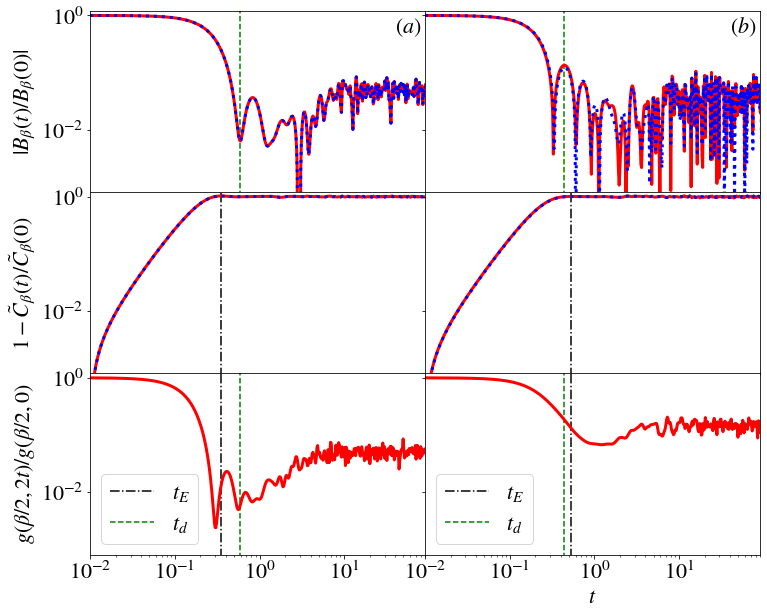

In [76]:
arr_minimaTPF=np.r_[True, TPF_ann[1:] < TPF_ann[:-1]] & np.r_[TPF_ann[:-1] < TPF_ann[1:], True]
t_d=np.min(t_arr2[arr_minimaTPF])
arr_minimaOTOC=np.r_[True, F_ann[1:] < F_ann[:-1]] & np.r_[F_ann[:-1] < F_ann[1:], True]
t_E=np.min(t_arr2[arr_minimaOTOC])
fig, ((ax1, ax4), (ax2, ax5), (ax3, ax6)) = plt.subplots(3, 2, sharex=True, sharey=True, figsize=[12, 10])
plt.subplots_adjust(hspace=0)
plt.subplots_adjust(wspace=0)
ax1.plot(t_arr2, ax1_b0, color='red', lw=3)
ax1.plot(t_arr2, ax1_b02, color='blue', ls=':', lw=3)
ax3.plot(t_arr2, ax3_b0, color='red', lw=3)
ax2.plot(t_arr2, ax2_b0, color='red', lw=3)
ax2.plot(t_arr2, ax2_b02, ls=':', color='blue', lw=3)
ax1.vlines(t_d_b0, 1e-4, 2, ls='--', color='green')
ax2.vlines(t_E_b0, 1e-4, 2, ls='-.')
ax3.vlines(t_E_b0, 1e-4, 2, ls='-.', label="$t_E$")
ax3.vlines(t_d_b0, 1e-4, 2, ls='--', label="$t_d$", color='green')
ax4.plot(t_arr2, np.abs(TPF_ann/TPF_ann[0]), color='red', lw=3)
ax4.plot(t_arr2, np.abs(TPF_Nann/TPF_Nann[0]), color='blue', ls=':', lw=3)
ax6.plot(t_arr2, SFF/SFF[0], color='red', lw=3)
ax5.plot(t_arr2, 1-F_ann/F_ann[0], color='red', lw=3)
ax5.plot(t_arr2, 1-F_unann/F_unann[0], ls=':', color='blue', lw=3)
ax4.vlines(t_d, 1e-4, 2, ls='--', color='green')
ax5.vlines(t_E, 1e-4, 2, ls='-.')
ax6.vlines(t_E, 1e-4, 2, ls='-.', label="$t_E$")
ax6.vlines(t_d, 1e-4, 2, ls='--', label="$t_d$", color='green')

plt.xlabel("$t$")
ax2.set_ylim(8e-4, 1.2)
ax2.set_xlim(t_arr2[0], 0.9*t_arr2[-1])
ax1.set_ylabel(r"$|B_\beta( t)/B_\beta( 0) |$")
ax2.set_ylabel(r"$1-\tilde{C}_\beta (t)/\tilde{C}_\beta (0)$")
ax3.set_ylabel(r"$g(\beta/2, 2t)/g(\beta/2, 0)$")
#plt.yscale('log')
plt.xscale('log')
ax1.text(4e1,0.5, r"$(a)$")
ax4.text(4e1,0.5, r"$(b)$")
ax3.set_yscale('log')
ax2.set_yscale('log')
#ax1.set_yscale('log')
#plt.xlim(0,1)
ax3.legend()
ax6.legend()
plt.show()

In [46]:
#Uncomment these lines to save the data at beta=0
"""ax1_b0=TPF_ann/TPF_ann[0]
ax1_b02=TPF_Nann/TPF_Nann[0]
t_d_b0=t_d
t_E_b0=t_E
ax3_b0=SFF/SFF[0]
ax2_b0=1-F_ann/F_ann[0]
ax2_b02=1-F_unann/F_unann[0]"""

'ax1_b0=TPF_ann/TPF_ann[0]\nax1_b02=TPF_Nann/TPF_Nann[0]\nt_d_b0=t_d\nt_E_b0=t_E\nax3_b0=SFF/SFF[0]\nax2_b0=1-F_ann/F_ann[0]\nax2_b02=1-F_unann/F_unann[0]'